In [3]:
from google.colab import files
import json

# Upload the dataset (this should be the fine-tuned dataset containing protein sequences for the target protein sequence you wish to work with)
uploaded = files.upload()

file_path = list(uploaded.keys())[0]  # Get the uploaded file name

# Load the dataset
with open(file_path, 'r') as file:
    sequences = json.load(file)

print(sequences[:5])  # Print the first 5 sequences to check

Saving uniref_100_NCAP.json to uniref_100_NCAP.json
['MASQGTKRSYEQMETDGERQNATEIRASVGKMIDGIGRFYIQMCTELKLSDYEGRLIQNSLTIERMVLSAFDERRNRYLEEHPSAGKDPKKTGGPIYKRVDRKWMRELVLYDKEEIRRIWRQANNGDDATAGLTHMMIWHSNLNDTTYQRTRALVRTGMDPRMCSLMQGSTLPRRSGAAGAAVKGVGTMVMELIRMIKRGINDRNFWRGENGRKTRGAYERMCNILKGKFQTAAQRAMMDQVRESRNPGNAEIEDLIFLARSALILRGSVAHKSCLPACVYGPAVASGYDFEKEGYSLVGIDPFKLLQNSQVYSLIRPNENPAHKSQLVWMACNSAAFEDLRLLSFIRGTKVSPRGKLSTRGVQIASNENMDTMESSTLELRSRYWAIRTRSGGNTNQQRASAGQISVQPAFSVQRNLPFDKSTIMAAFTGNTEGRTSDMRAEIIRMMEGAKPEEVSFRGRGVFELSDEKATNPIVPSFDMSNEGSYFFGDNAEEYDN', 'MASQGTKRSYEQMETGGERQNATEIRASVGRMVGGIGRFYIQMCTELKLTDYEGRLIQNSITIERMVLSAFDERRNKYLEEHPSAGKDPKKTGGPIYRRRDGKWVRELILYDKEEIRRIWRQANNGEDATAGLTHLMIWHSNLNDATYQRTRALVRTGMDPRMCSLMQGSTLPRRSGAAGAAVKGVGTMVMELIRMIKRGINDRNFWRGENGRRTRIAYERMCNILKGKFQTAAQRAMMDQVRESRNPGNAEIEDLIFLARSALILRGSVAHKSCLPACVYGLAVASGYDFEREGYSLVGIDPFRLLQNSQVFSLIRPNENPAHKSQLVWMACHSAAFEDLRVSSFIRGTRVVPRGQLSTRGVQIASNENMEAMDSSTLELRSRYWAIRTRSGGNTNQQRASAGQISVQPTFSVQRNLPFERATIMAAFTGNTEGRTSDMRTEI

In [7]:
# Install required packages and import necessary libraries
!pip install transformers datasets evaluate
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM
import random
import json
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from torch.utils.data import Dataset
from scipy.stats import spearmanr
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [8]:
# Load pre-trained model and tokenizer for ESM-2 based on the chosen model size


# Uncomment and modify the line below if you want to use the 8M parameter model
# model_name = "facebook/esm2_t6_8M_UR50D"

# Use this line for the 35M parameter model
model_name = "facebook/esm2_t12_35M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

NO FINE TUNING - ZERO SHOT SPEARMAN CORRELATION BASELINE

In [11]:
# Load mutation data from a JSON file containing mutation information for the SPECIFIC target protein
with open("in_vitro_scores_NCAP.json", "r") as f:
    mutation_data = json.load(f)

# If the loaded mutation data is a list, select the entry for protein "NCAP_I34A1"
if isinstance(mutation_data, list):
    found = False
    for entry in mutation_data:
        # If the entry is a string, try to parse it into a dictionary
        if isinstance(entry, str):
            try:
                entry = json.loads(entry)
            except Exception as e:
                print(f"Could not parse entry due to error: {e}")
                continue
        # If the entry is a dictionary and matches the target protein, store it
        if isinstance(entry, dict) and entry.get("protein") == "NCAP_I34A1":
            mutation_dataset = entry
            found = True
            break
    if not found:
        raise ValueError("No mutation data found for protein NCAP_I34A1 in the JSON file.")
elif isinstance(mutation_data, dict):
    mutation_dataset = mutation_data  # If the data is already a dictionary, use it directly
else:
    raise ValueError("Unexpected format for mutation_data")

# Check if the necessary key 'cellular_impact_scores' exists in the mutation dataset
if "cellular_impact_scores" not in mutation_dataset:
    raise ValueError("mutation_dataset does not contain the 'cellular_impact_scores' key.")

# Define the target sequence for evaluation.
# This sequence represents the protein for which the fine-tuned dataset was made and that is being evaluated. The corresponding sequence
# can be found in the ProteinGym_reference_file_substitutions.csv if necessary.
target_sequence = (
    "MASQGTKRSYEQMETDGERQNATEIRASVGKMIGGIGRFYIQMCTELKLSDYEGRLIQNSLTIERMVLSAFDERRNKYLEEHPSAGKDPKKTGGPIYRRVNGKWMRELILYDKEEIRRIWRQANNGDDATAGLTHMMIWHSNLNDATYQRTRALVRTGMDPRMCSLMQGSTLPRRSGAAGAAVKGVGTMVMELVRMIKRGINDRNFWRGENGRKTRIAYERMCNILKGKFQTAAQKAMMDQVRESRNPGNAEFEDLTFLARSALILRGSVAHKSCLPACVYGPAVASGYDFEREGYSLVGIDPFRLLQNSQVYSLIRPNENPAHKSQLVWMACHSAAFEDLRVLSFIKGTKVLPRGKLSTRGVQIASNENMETMESSTLELRSRYWAIRTRSGGNTNQQRASAGQISIQPTFSVQRNLPFDRTTIMAAFNGNTEGRTSDMRTEIIRMMESARPEDVSFQGRGVFELSDEKAASPIVPSFDMSNEGSYFFGDNAEEYDN"
)

# Function to compute Spearman correlation for the target sequence
def compute_spearman(model, tokenizer, target_sequence, mutation_dataset):
    # Tokenize the target sequence to convert it into model-readable format (input_ids)
    encoded_seq = tokenizer(target_sequence, return_tensors="pt", padding=True, truncation=True)
    # print('encoded', encoded_seq)
    input_ids = encoded_seq["input_ids"]  # Get input ids from the tokenized sequence
    # print('input_ids', input_ids)
    if torch.cuda.is_available():
        input_ids = input_ids.to(model.device)
    sequence_length = input_ids.shape[1]

    llr_list = []  # List to collect computed log likelihood ratio (LLR) values
    gt_list = []   # List to collect corresponding ground-truth impact scores

    # Process each token position (skip first and last tokens)
    for position in range(1, sequence_length - 1):
        masked_input_ids = input_ids.clone() # Clone the input_ids to create a masked version
        # print('masked_input_ids', masked_input_ids)
        masked_input_ids[0, position] = tokenizer.mask_token_id  # Mask the current token position
        # print('masked_input_ids_position', tokenizer.mask_token_id)

        with torch.no_grad():
            logits = model(masked_input_ids).logits  # Get the logits (raw model predictions) for the masked token

        # Convert logits to probabilities using softmax
        probs = F.softmax(logits[0, position], dim=0)
        log_probs = torch.log(probs)  # Compute the log of the probabilities

        # Get the original token ID at the current position in the sequence
        wt_token_id = input_ids[0, position].item()
        if wt_token_id in [tokenizer.pad_token_id, tokenizer.mask_token_id]:
            continue  # Skip padding and masked tokens

        wt_log_prob = log_probs[wt_token_id].item()  # Log probability of the original token
        wt_token = tokenizer.decode([wt_token_id]).strip()  # Decode the token to its string representation

        # Evaluate every possible amino acid substitution at this position
        for aa in list("ACDEFGHIKLMNPQRSTVWY"):
            aa_id = tokenizer.convert_tokens_to_ids(aa)  # Convert the amino acid to its token ID
            if aa_id is None:
                continue  # Skip invalid amino acids

            mut_log_prob = log_probs[aa_id].item()  # Log probability of the mutated amino acid
            llr = mut_log_prob - wt_log_prob  # Compute log-likelihood ratio (LLR)
            mutation_label = f"{wt_token}{position}{aa}"  # Create a mutation label

            # If the mutation label exists in the mutation dataset, collect the LLR and ground-truth score
            if mutation_label in mutation_dataset["cellular_impact_scores"]:
                gt_score = mutation_dataset["cellular_impact_scores"][mutation_label]
                llr_list.append(llr)
                gt_list.append(gt_score)

    if len(llr_list) > 1:
        spearman_corr, _ = spearmanr(llr_list, gt_list)  # Calculate Spearman correlation
    else:
        spearman_corr = None

    return spearman_corr, llr_list, gt_list

spearman_corr, llr_list, gt_list = compute_spearman(model, tokenizer, target_sequence, mutation_dataset)
print("Spearman correlation:", spearman_corr)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Spearman correlation: 0.02624018567833795


FINE - TUNING PROCESS

Number of tokenized sequences: 2
Dataset size: 11603


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aylincyn25 (aylincyn25-princeton-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,2.588100
20,2.398000
30,2.100700
40,1.707100
50,1.349600
60,1.064100
70,0.799600
80,0.606600
90,0.488800
100,0.375500


Epoch 1.0 average Spearman correlation: 0.37106929752496476
Epoch 1.0 metrics:
Highest Spearman correlation: 0.4033488790380662
Corresponding highest entropy: 0.10478987478338796
Epoch 2.0 average Spearman correlation: 0.40074800558355317
Epoch 2.0 metrics:
Highest Spearman correlation: 0.4078991922459264
Corresponding highest entropy: 0.10080547670269924
Epoch 3.0 average Spearman correlation: 0.40125086492162076
Epoch 3.0 metrics:
Highest Spearman correlation: 0.4078991922459264
Corresponding highest entropy: 0.10080547670269924
Training finished.
Final Spearman correlation: 0.40221360819606805
Final entropy: 0.09683122687639265


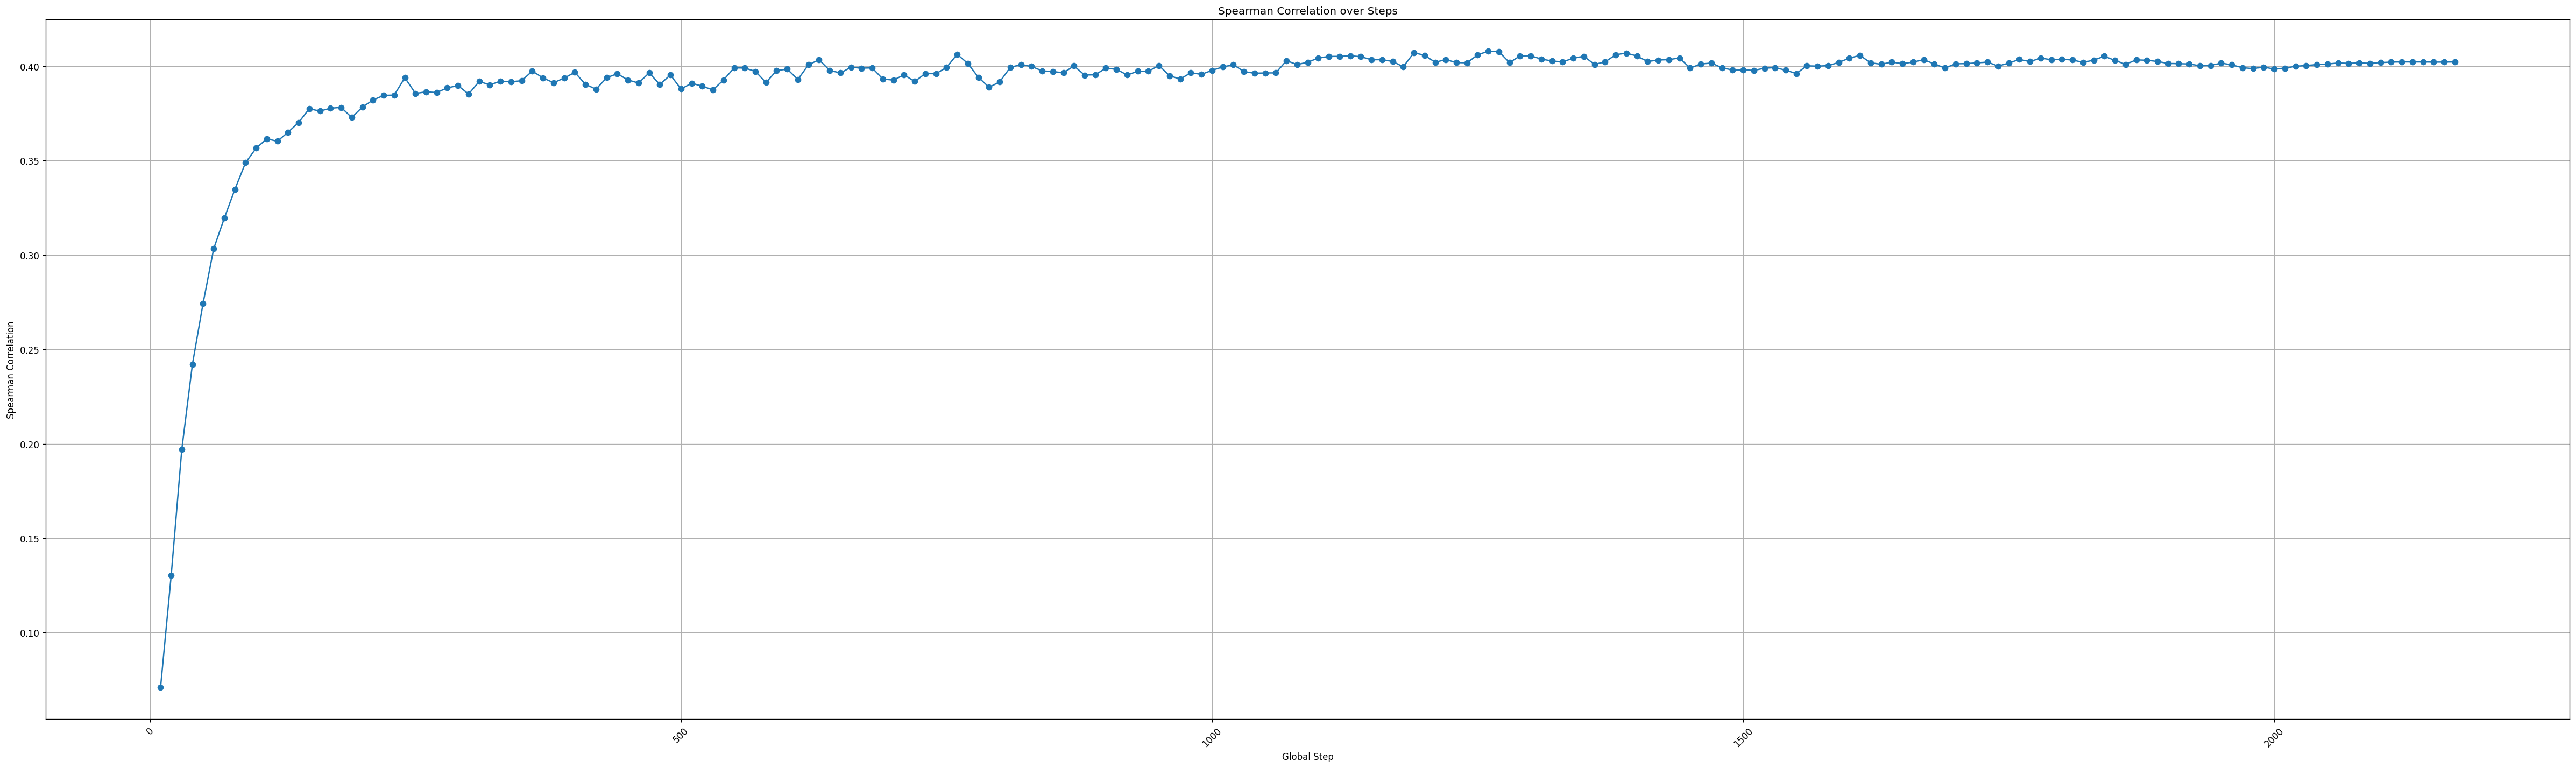

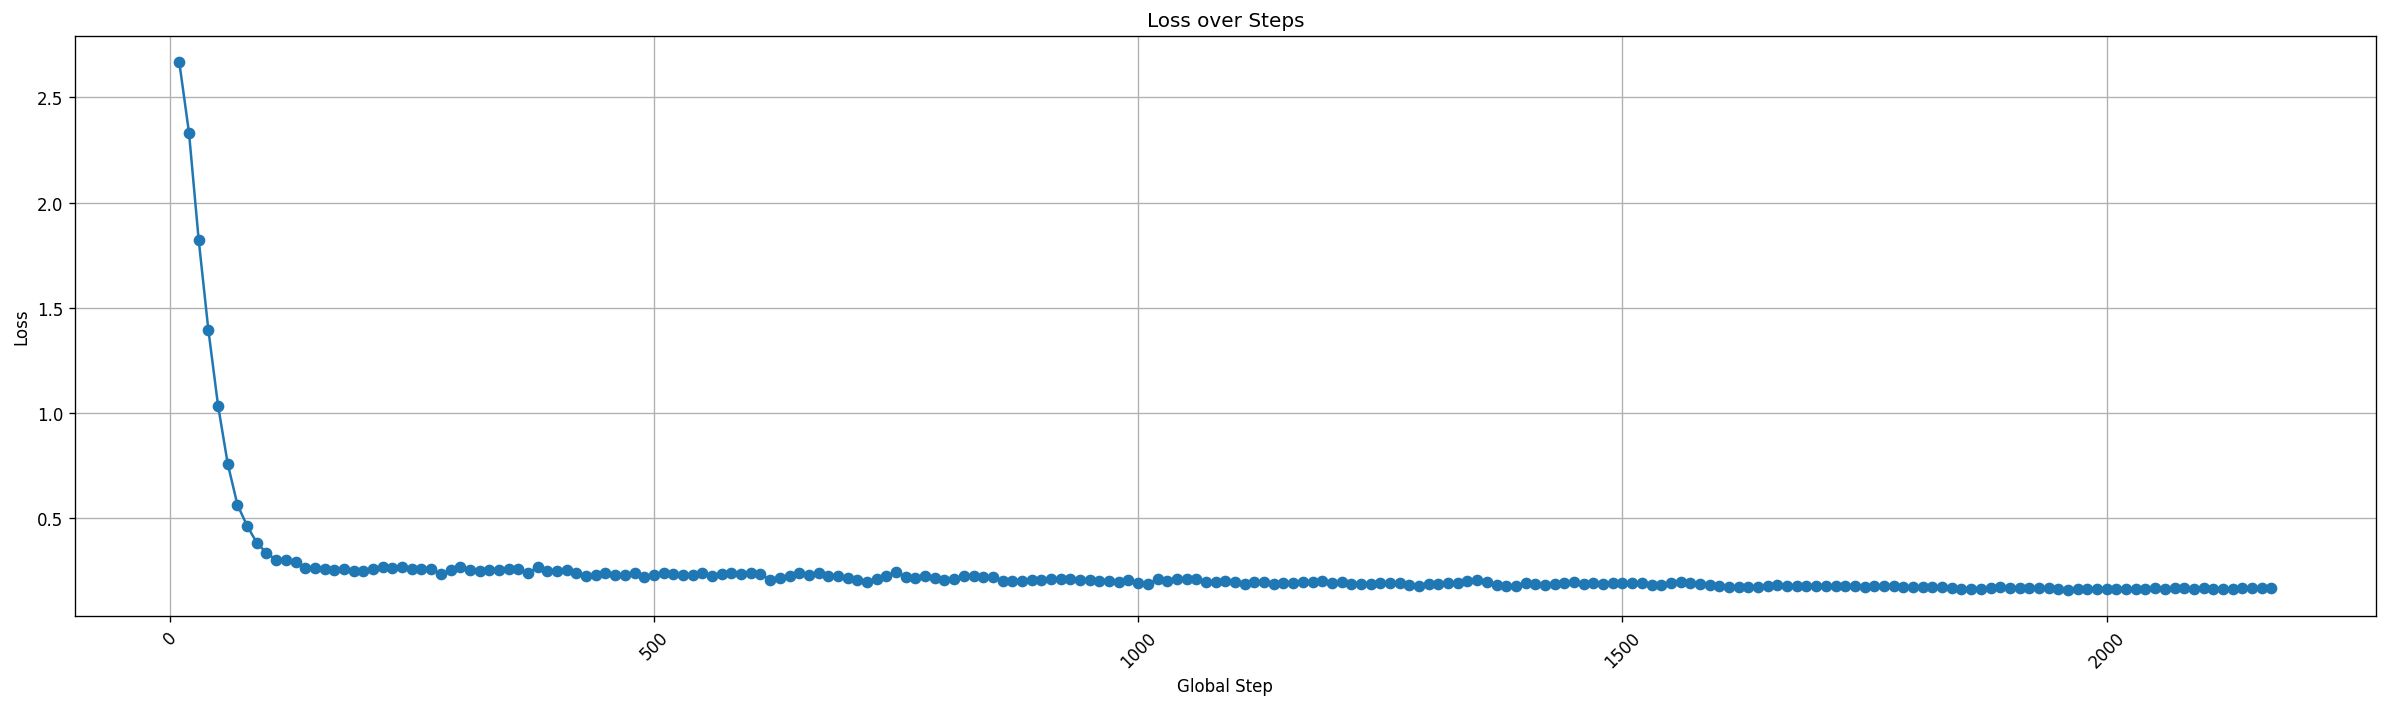

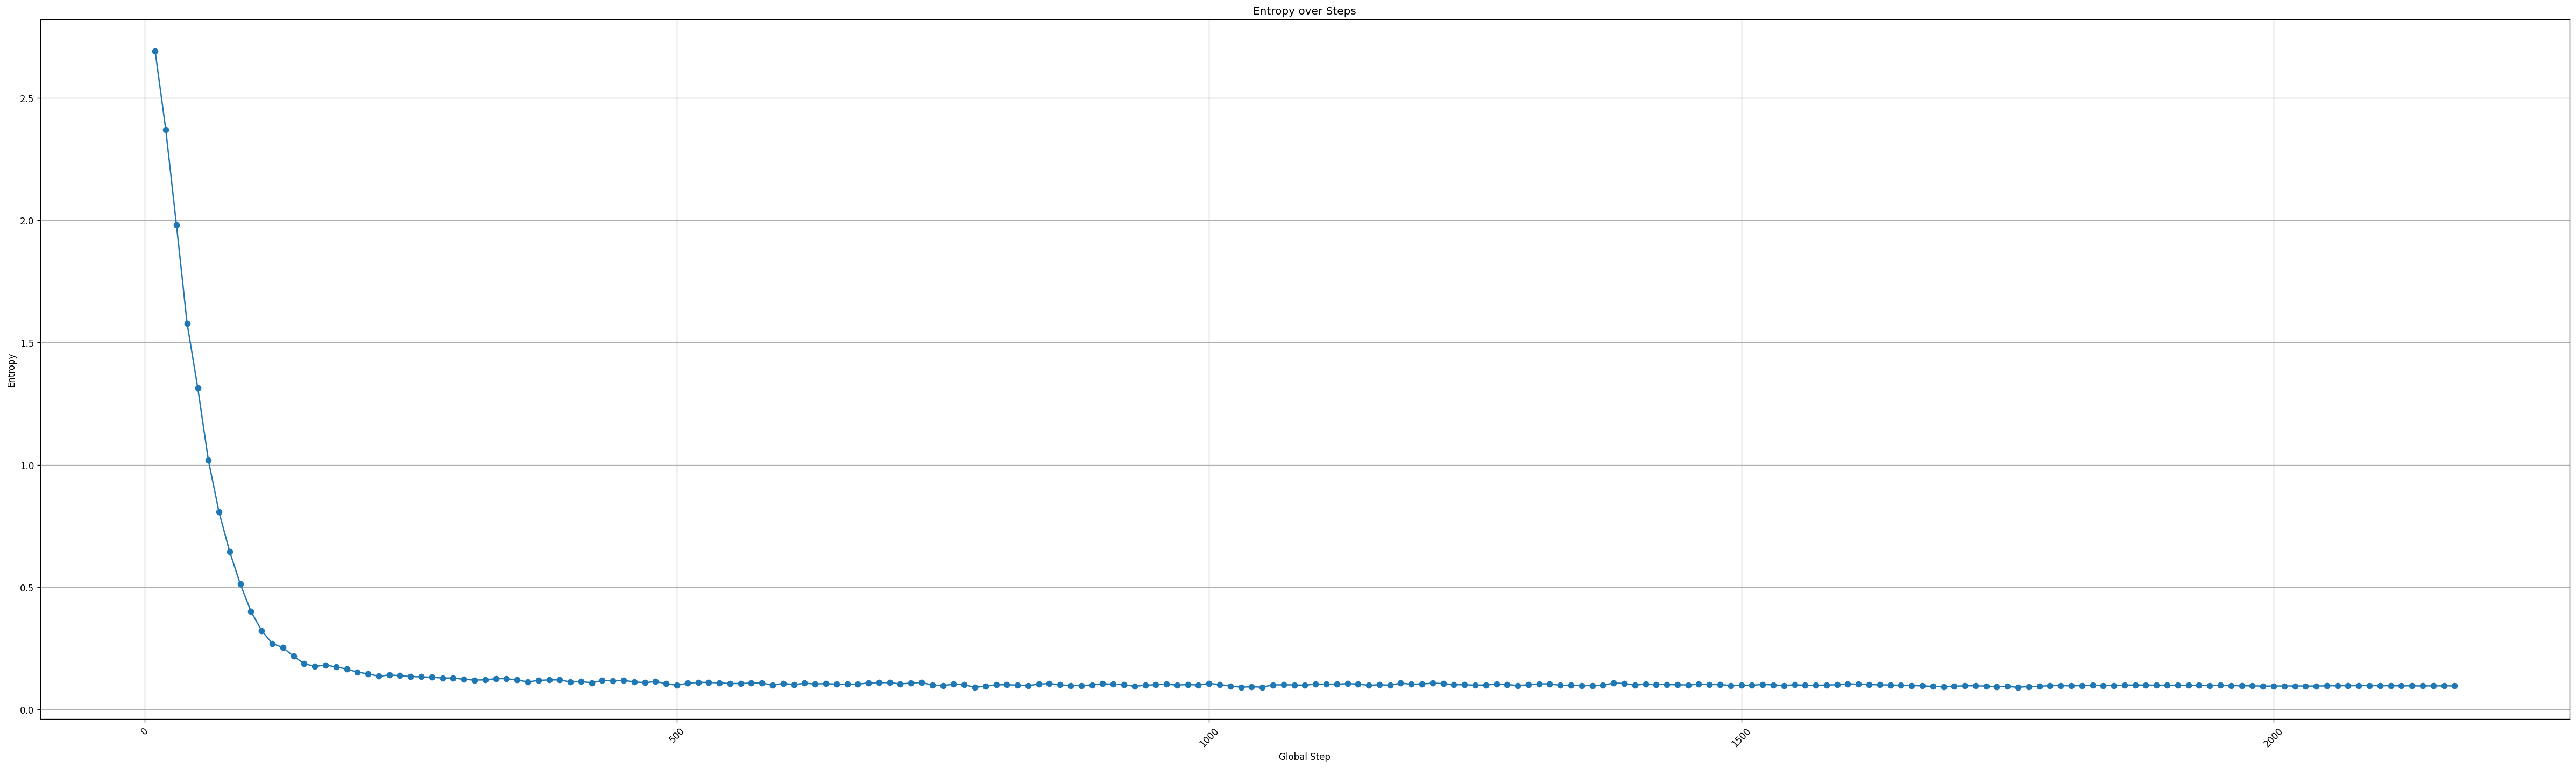

<Figure size 640x480 with 0 Axes>

TrainOutput(global_step=2178, training_loss=0.1483145214692511, metrics={'train_runtime': 5064.2164, 'train_samples_per_second': 6.874, 'train_steps_per_second': 0.43, 'total_flos': 3517776723243348.0, 'train_loss': 0.1483145214692511, 'epoch': 3.0})

In [13]:
# Tokenize the sequences for model input.
tokenized_sequences = tokenizer(
    sequences,
    padding=True,
    truncation=True,
    max_length=1024,
    return_tensors="pt"
)

# Define a custom Dataset class to handle tokenized sequences
class ProteinDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings  # Store the tokenized sequences

    def __getitem__(self, idx):
        # Return a dictionary with all keys for the given index
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

    def __len__(self):
        # Return the length of the dataset (number of sequences)
        return len(self.encodings['input_ids'])

# Initialize the dataset with tokenized sequences
train_dataset = ProteinDataset(tokenized_sequences)

# Data collator prepares the data for masked language modeling with a masking probability of 15%
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm_probability=0.15, return_tensors="pt"
)

# Print the number of tokenized sequences and the size of the dataset
print(f"Number of tokenized sequences: {len(tokenized_sequences)}")
print(f"Dataset size: {len(train_dataset)}")

# Load mutation data from a JSON file containing mutation information for the SPECIFIC target protein
with open("in_vitro_scores_NCAP.json", "r") as f:
    mutation_data = json.load(f)

# If the loaded mutation data is a list, select the entry for protein "NCAP_I34A1"
if isinstance(mutation_data, list):
    found = False
    for entry in mutation_data:
        # If the entry is a string, try to parse it into a dictionary
        if isinstance(entry, str):
            try:
                entry = json.loads(entry)
            except Exception as e:
                print(f"Could not parse entry due to error: {e}")
                continue
        # If the entry is a dictionary and matches the target protein, store it
        if isinstance(entry, dict) and entry.get("protein") == "NCAP_I34A1":
            mutation_dataset = entry
            found = True
            break
    if not found:
        raise ValueError("No mutation data found for protein NCAP_I34A1 in the JSON file.")
elif isinstance(mutation_data, dict):
    mutation_dataset = mutation_data  # If the data is already a dictionary, use it directly
else:
    raise ValueError("Unexpected format for mutation_data")

# Check if the necessary key 'cellular_impact_scores' exists in the mutation dataset
if "cellular_impact_scores" not in mutation_dataset:
    raise ValueError("mutation_dataset does not contain the 'cellular_impact_scores' key.")

# Define the target sequence for evaluation.
# This sequence represents the protein for which the fine-tuned dataset was made and that is being evaluated. The corresponding sequence
# can be found in the ProteinGym_reference_file_substitutions.csv if necessary.
target_sequence = (
    "MASQGTKRSYEQMETDGERQNATEIRASVGKMIGGIGRFYIQMCTELKLSDYEGRLIQNSLTIERMVLSAFDERRNKYLEEHPSAGKDPKKTGGPIYRRVNGKWMRELILYDKEEIRRIWRQANNGDDATAGLTHMMIWHSNLNDATYQRTRALVRTGMDPRMCSLMQGSTLPRRSGAAGAAVKGVGTMVMELVRMIKRGINDRNFWRGENGRKTRIAYERMCNILKGKFQTAAQKAMMDQVRESRNPGNAEFEDLTFLARSALILRGSVAHKSCLPACVYGPAVASGYDFEREGYSLVGIDPFRLLQNSQVYSLIRPNENPAHKSQLVWMACHSAAFEDLRVLSFIKGTKVLPRGKLSTRGVQIASNENMETMESSTLELRSRYWAIRTRSGGNTNQQRASAGQISIQPTFSVQRNLPFDRTTIMAAFNGNTEGRTSDMRTEIIRMMESARPEDVSFQGRGVFELSDEKAASPIVPSFDMSNEGSYFFGDNAEEYDN"
)


# Custom Callback for Batch Metrics & Spearman, Loss, and Entropy Tracking
class BatchMetricsCallback(TrainerCallback):
    def __init__(self, tokenizer, data_collator, logging_steps):
        self.tokenizer = tokenizer
        self.data_collator = data_collator  # Data collator for masking and preparing batches
        self.logging_steps = logging_steps
        self.global_steps = []
        self.step_spearman = []
        self.step_loss = []
        self.step_entropy = []
        self.epoch_spearman = []
        self.highest_spearman = -1
        self.highest_entropy = None
        self.last_spearman = None
        self.last_entropy = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        # Reset the Spearman correlation list at the start of each epoch
        self.step_spearman_epoch = []
        return control

    def on_step_end(self, args, state, control, model=None, **kwargs):
        # Compute metrics only at the specified logging steps
        if state.global_step % self.logging_steps != 0:
            return control

        # Tokenize the target sequence for evaluation
        encoded_seq = self.tokenizer(target_sequence, return_tensors="pt", padding=True, truncation=True)
        input_ids = encoded_seq["input_ids"].to(model.device)
        sequence_length = input_ids.shape[1]

        llr_list = []
        gt_list = []
        losses = []
        entropies = []

        # Process each token position
        for position in range(1, sequence_length - 1):
            masked_input_ids = input_ids.clone()
            masked_input_ids[0, position] = self.tokenizer.mask_token_id

            # Get model's logits for the masked token
            with torch.no_grad():
                logits = model(masked_input_ids).logits
            probs = F.softmax(logits[0, position], dim=0)
            log_probs = torch.log(probs)

            wt_token_id = input_ids[0, position].item()
            if wt_token_id in [self.tokenizer.pad_token_id, self.tokenizer.mask_token_id]:
                continue  # Skip padding and mask tokens

            # Compute negative log likelihood for the wildtype token
            loss_i = -log_probs[wt_token_id].item()
            losses.append(loss_i)

            # Compute entropy for this position (measure of uncertainty in the distribution)
            entropy_i = -torch.sum(probs * log_probs).item()
            entropies.append(entropy_i)

            wt_log_prob = log_probs[wt_token_id].item()
            wt_token = self.tokenizer.decode([wt_token_id]).strip()

            # Evaluate every possible amino acid substitution at this position
            for aa in list("ACDEFGHIKLMNPQRSTVWY"):
                aa_id = self.tokenizer.convert_tokens_to_ids(aa)
                if aa_id is None:
                    continue  # Skip invalid amino acids

                mut_log_prob = log_probs[aa_id].item()  # Log probability for the mutated amino acid
                llr = mut_log_prob - wt_log_prob  # Compute log-likelihood ratio (LLR)
                mutation_label = f"{wt_token}{position}{aa}"  # Create the mutation label
                if mutation_label in mutation_dataset["cellular_impact_scores"]:
                    gt_score = mutation_dataset["cellular_impact_scores"][mutation_label]
                    llr_list.append(llr)
                    gt_list.append(gt_score)

        # Calculate average loss and entropy for the current batch
        avg_loss = np.mean(losses) if losses else None
        avg_entropy = np.mean(entropies) if entropies else None

        # Compute Spearman correlation if there are enough data points
        if len(llr_list) > 1:
            spearman_corr, _ = spearmanr(llr_list, gt_list)
        else:
            spearman_corr = None

        # Save the computed metrics
        self.global_steps.append(state.global_step)
        self.step_spearman.append(spearman_corr)
        self.step_loss.append(avg_loss)
        self.step_entropy.append(avg_entropy)
        self.step_spearman_epoch.append(spearman_corr)
        if spearman_corr > self.highest_spearman:
            self.highest_spearman = spearman_corr
            self.highest_entropy = avg_entropy

        # Store the last correlation and entropy at each step
        self.last_spearman = spearman_corr
        self.last_entropy = avg_entropy
        return control

    def on_epoch_end(self, args, state, control, **kwargs):
       # Compute average Spearman correlation for the epoch.
        valid_correlations = [s for s in self.step_spearman_epoch if s is not None]
        if valid_correlations:
            avg_epoch_spearman = np.mean(valid_correlations)
        else:
            avg_epoch_spearman = None

        self.epoch_spearman.append(avg_epoch_spearman)
        print(f"Epoch {state.epoch} average Spearman correlation: {avg_epoch_spearman}")
        print(f"Epoch {state.epoch} metrics:")
        print(f"Highest Spearman correlation: {self.highest_spearman}")
        print(f"Corresponding highest entropy: {self.highest_entropy}")

        if state.epoch == args.num_train_epochs:
         # Plot Spearman Correlation
          print("Training finished.")
          print(f"Final Spearman correlation: {self.last_spearman}")
          print(f"Final entropy: {self.last_entropy}")
          plt.figure(figsize=(40, 12), dpi=120)
          plt.plot(self.global_steps, self.step_spearman, marker='o', linestyle='-')
          plt.xlabel("Global Step")
          plt.ylabel("Spearman Correlation")
          plt.title("Spearman Correlation over Steps")
          plt.grid(True)
          plt.xticks(rotation=45)
          plt.tight_layout()
          plt.savefig(f"spearman_global_step_epoch{state.epoch}.png")
          plt.show()

          # Plot Loss
          plt.figure(figsize=(20, 6), dpi=120)
          plt.plot(self.global_steps, self.step_loss, marker='o', linestyle='-')
          plt.xlabel("Global Step")
          plt.ylabel("Loss")
          plt.title("Loss over Steps")
          plt.grid(True)
          plt.xticks(rotation=45)
          plt.tight_layout()
          plt.savefig(f"loss_global_step_epoch{state.epoch}.png")
          plt.show()

          # Plot Entropy
          plt.figure(figsize=(40, 12), dpi=120)
          plt.plot(self.global_steps, self.step_entropy, marker='o', linestyle='-')
          plt.xlabel("Global Step")
          plt.ylabel("Entropy")
          plt.title("Entropy over Steps")
          plt.grid(True)
          plt.xticks(rotation=45)
          plt.tight_layout()
          plt.savefig(f"entropy_global_step_epoch{state.epoch}.png")
          plt.show()

          plt.tight_layout()
          plt.savefig(f"metrics_global_step_epoch{state.epoch}.png")
          plt.show()

        return control

batch_size = 16
logging_steps = 10

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    logging_steps=logging_steps,
)

# Set up the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
    callbacks=[BatchMetricsCallback(tokenizer, data_collator, logging_steps)],
)

trainer.train()  # Begin training the model


WORK WITH THE NEW MODEL

In [14]:
# After trainer.train()
trainer.save_model("./results")
tokenizer.save_pretrained("./results")

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json')

In [16]:
# Load mutation data from a JSON file containing mutation information for the SPECIFIC target protein
with open("in_vitro_scores_NCAP.json", "r") as f:
    mutation_data = json.load(f)

# If the loaded mutation data is a list, select the entry for protein "NCAP_I34A1"
if isinstance(mutation_data, list):
    found = False
    for entry in mutation_data:
        # If the entry is a string, try to parse it into a dictionary
        if isinstance(entry, str):
            try:
                entry = json.loads(entry)
            except Exception as e:
                print(f"Could not parse entry due to error: {e}")
                continue
        # If the entry is a dictionary and matches the target protein, store it
        if isinstance(entry, dict) and entry.get("protein") == "NCAP_I34A1":
            mutation_dataset = entry
            found = True
            break
    if not found:
        raise ValueError("No mutation data found for protein NCAP_I34A1 in the JSON file.")
elif isinstance(mutation_data, dict):
    mutation_dataset = mutation_data  # If the data is already a dictionary, use it directly
else:
    raise ValueError("Unexpected format for mutation_data")

# Check if the necessary key 'cellular_impact_scores' exists in the mutation dataset
if "cellular_impact_scores" not in mutation_dataset:
    raise ValueError("mutation_dataset does not contain the 'cellular_impact_scores' key.")

# Define the target sequence for evaluation.
# This sequence represents the protein for which the fine-tuned dataset was made and that is being evaluated. The corresponding sequence
# can be found in the ProteinGym_reference_file_substitutions.csv if necessary.
target_sequence = (
    "MASQGTKRSYEQMETDGERQNATEIRASVGKMIGGIGRFYIQMCTELKLSDYEGRLIQNSLTIERMVLSAFDERRNKYLEEHPSAGKDPKKTGGPIYRRVNGKWMRELILYDKEEIRRIWRQANNGDDATAGLTHMMIWHSNLNDATYQRTRALVRTGMDPRMCSLMQGSTLPRRSGAAGAAVKGVGTMVMELVRMIKRGINDRNFWRGENGRKTRIAYERMCNILKGKFQTAAQKAMMDQVRESRNPGNAEFEDLTFLARSALILRGSVAHKSCLPACVYGPAVASGYDFEREGYSLVGIDPFRLLQNSQVYSLIRPNENPAHKSQLVWMACHSAAFEDLRVLSFIKGTKVLPRGKLSTRGVQIASNENMETMESSTLELRSRYWAIRTRSGGNTNQQRASAGQISIQPTFSVQRNLPFDRTTIMAAFNGNTEGRTSDMRTEIIRMMESARPEDVSFQGRGVFELSDEKAASPIVPSFDMSNEGSYFFGDNAEEYDN"
)

# Function to compute Spearman correlation for the target sequence
def compute_spearman(model, tokenizer, target_sequence, mutation_dataset):
    # Tokenize the target sequence to convert it into model-readable format (input_ids)
    encoded_seq = tokenizer(target_sequence, return_tensors="pt", padding=True, truncation=True)
    # print('encoded', encoded_seq)
    input_ids = encoded_seq["input_ids"]  # Get input ids from the tokenized sequence
    # print('input_ids', input_ids)
    if torch.cuda.is_available():
        input_ids = input_ids.to(model.device)
    sequence_length = input_ids.shape[1]

    llr_list = []  # List to collect computed log likelihood ratio (LLR) values
    gt_list = []   # List to collect corresponding ground-truth impact scores

    # Process each token position (skip first and last tokens)
    for position in range(1, sequence_length - 1):
        masked_input_ids = input_ids.clone() # Clone the input_ids to create a masked version
        # print('masked_input_ids', masked_input_ids)
        masked_input_ids[0, position] = tokenizer.mask_token_id  # Mask the current token position
        # print('masked_input_ids_position', tokenizer.mask_token_id)

        with torch.no_grad():
            logits = model(masked_input_ids).logits  # Get the logits (raw model predictions) for the masked token

        # Convert logits to probabilities using softmax
        probs = F.softmax(logits[0, position], dim=0)
        log_probs = torch.log(probs)  # Compute the log of the probabilities

        # Get the original token ID at the current position in the sequence
        wt_token_id = input_ids[0, position].item()
        if wt_token_id in [tokenizer.pad_token_id, tokenizer.mask_token_id]:
            continue  # Skip padding and masked tokens

        wt_log_prob = log_probs[wt_token_id].item()  # Log probability of the original token
        wt_token = tokenizer.decode([wt_token_id]).strip()  # Decode the token to its string representation

        # Evaluate every possible amino acid substitution at this position
        for aa in list("ACDEFGHIKLMNPQRSTVWY"):
            aa_id = tokenizer.convert_tokens_to_ids(aa)  # Convert the amino acid to its token ID
            if aa_id is None:
                continue  # Skip invalid amino acids

            mut_log_prob = log_probs[aa_id].item()  # Log probability of the mutated amino acid
            llr = mut_log_prob - wt_log_prob  # Compute log-likelihood ratio (LLR)
            mutation_label = f"{wt_token}{position}{aa}"  # Create a mutation label

            # If the mutation label exists in the mutation dataset, collect the LLR and ground-truth score
            if mutation_label in mutation_dataset["cellular_impact_scores"]:
                gt_score = mutation_dataset["cellular_impact_scores"][mutation_label]
                llr_list.append(llr)
                gt_list.append(gt_score)

    if len(llr_list) > 1:
        spearman_corr, _ = spearmanr(llr_list, gt_list)  # Calculate Spearman correlation
    else:
        spearman_corr = None

    return spearman_corr, llr_list, gt_list

spearman_corr, llr_list, gt_list = compute_spearman(model, tokenizer, target_sequence, mutation_dataset)
print("Spearman correlation:", spearman_corr)

Spearman correlation: 0.4022391351229015
